In [1]:
import pandas as pd
import tensorflow as tf
import pickle
from sklearn.model_selection import train_test_split
from tensorflow.keras.regularizers import l2

In [2]:
data = pd.read_csv('../data/full_data.csv')
data.head()

,movieId,userId,title,genres,rating,tag
0,1,2483,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,4.0,lots of heart
1,1,31107,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.0,animation
2,1,31107,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.0,family
3,1,31107,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.0,sci-fi
4,1,82148,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,4.0,Animation


# Filtragem Colaborativa

### O que é Filtragem Colaborativa?

A filtragem colaborativa é uma técnica que pode filtrar itens que um usuário pode gostar com base nas reações de usuários semelhantes.

Ela funciona pesquisando um grande grupo de pessoas e encontrando um conjunto menor de usuários com gostos semelhantes a um usuário particular. Observa os itens que eles gostam e os combina para criar uma lista classificada de sugestões.

Existem muitas maneiras de decidir quais usuários são semelhantes e combinar suas escolhas para criar uma lista de recomendações.

# O Conjunto de Dados

Primeiro precisamos de dados que contenham um conjunto de itens e um conjunto de usuários que reagiram a alguns dos itens.

A reação pode ser explícita (avaliação em uma escala de 1 a 5, gostos ou desgostos) ou implícita (visualizar um item, adicioná-lo a uma lista de desejos, o tempo gasto em um artigo).

Ao trabalhar com esses dados, você geralmente os verá na forma de uma matriz, consistindo das reações dadas por um conjunto de usuários a alguns itens de um conjunto de itens. Cada linha conteria as avaliações dadas por um usuário, e cada coluna conteria as avaliações recebidas por um item.
Uma matriz com cinco usuários e cinco itens poderia ter esta aparência:

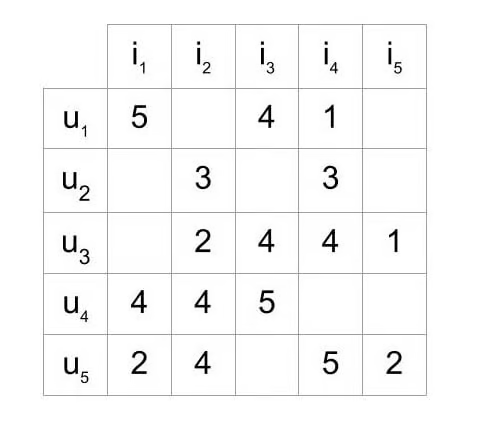

- **Linhas (`U1` a `U5`)**: Cada linha representa um usuário diferente. Por exemplo, `U1` é o usuário 1, `U2` é o usuário 2, e assim por diante.
- **Colunas (`i1` a `i5`)**: Cada coluna representa um item diferente. Por exemplo, `i1` poderia ser um filme, um livro, ou qualquer outro produto ou serviço que está sendo avaliado.
- **Células da matriz**: Cada célula contém uma avaliação que o usuário daquela linha deu para o item daquela coluna. As avaliações são explicitamente dadas numa escala de 1 a 5, onde números mais altos indicam uma preferência ou apreciação maior pelo item. Por exemplo, o usuário `U1` deu uma avaliação de 5 para o item `i1` e uma avaliação de 1 para o item `i4`.

Na maioria dos casos, as células da matriz estão vazias, pois os usuários avaliam apenas alguns itens. É altamente improvável que todos os usuários avaliem ou reajam a todos os itens disponíveis, como ja haviamos verificado na EDA. Uma matriz com células quase todas vazias é chamada de esparsa, e o oposto disso (uma matriz quase toda preenchida) é chamada de densa.

In [7]:
# Dividindo os dados em treino e teste
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Configurações dos IDs e do tamanho dos embeddings
num_users = train_data['userId'].max() + 1
num_movies = train_data['movieId'].max() + 1
embedding_dimension = 10

# Inputs para User e Movie IDs
user_input = tf.keras.layers.Input(shape=(1,), name='user_id', dtype=tf.int32)
movie_input = tf.keras.layers.Input(shape=(1,), name='movie_id', dtype=tf.int32)

# Embeddings para User e Movie
user_embedding = tf.keras.layers.Embedding(num_users, embedding_dimension)(user_input)
movie_embedding = tf.keras.layers.Embedding(num_movies, embedding_dimension)(movie_input)
user_vec = tf.keras.layers.Flatten()(user_embedding)
movie_vec = tf.keras.layers.Flatten()(movie_embedding)

# Filtragem baseada em conteúdo

In [8]:
# Criando conjuntos únicos de gêneros e tags para uso como vocabulário nas colunas de recursos
genre_vocab = set('|'.join(train_data['genres']).split('|'))  # Usar apenas dados de treino
tag_vocab = set(train_data['tag'].unique())  # Usar apenas dados de treino

# Inputs para gêneros e tags
genres_input = tf.keras.layers.Input(shape=(1,), name='genres', dtype=tf.string)
tags_input = tf.keras.layers.Input(shape=(1,), name='tag', dtype=tf.string)

# Definir as colunas de recursos categóricos
genre_column = tf.feature_column.categorical_column_with_vocabulary_list('genres', list(genre_vocab))
tag_column = tf.feature_column.categorical_column_with_vocabulary_list('tag', list(tag_vocab))
genre_one_hot = tf.feature_column.indicator_column(genre_column)
tag_one_hot = tf.feature_column.indicator_column(tag_column)
feature_columns = [genre_one_hot, tag_one_hot]

# Camada de recursos
feature_layer_inputs = {'genres': genres_input, 'tag': tags_input}
feature_layer = tf.keras.layers.DenseFeatures(feature_columns)(feature_layer_inputs)

# Combinar todas as entradas
combined_inputs = tf.keras.layers.concatenate([user_vec, movie_vec, feature_layer])

In [ ]:
# Salvar genre_vocab e tag_vocab como pickle
with open('../data/genre_vocab.pkl', 'wb') as f:
    pickle.dump(genre_vocab, f)
with open('../data/tag_vocab.pkl', 'wb') as f:
    pickle.dump(tag_vocab, f)

In [9]:
# Construir a rede neural
dense_1 = tf.keras.layers.Dense(128, activation='relu')(combined_inputs)
dense_2 = tf.keras.layers.Dense(64, activation='relu')(dense_1)
output = tf.keras.layers.Dense(1, activation='linear')(dense_2)

# Criar o modelo
inputs = [user_input, movie_input, genres_input, tags_input]
model = tf.keras.models.Model(inputs=inputs, outputs=output)

# Compilar o modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Visualizar a arquitetura do modelo
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user_id (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 movie_id (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1, 10)        3309240     ['user_id[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 1, 10)        2889560     ['movie_id[0][0]']               
                                                                                              

In [10]:
def prepare_dataset(data):
    # Assegurando que todos os campos estejam no tipo correto
    features = {
        'user_id': data['userId'].values,
        'movie_id': data['movieId'].values,
        'genres': data['genres'].values.astype(str),
        'tag': data['tag'].values.astype(str)
    }
    labels = data['rating'].values
    return features, labels

train_features, train_labels = prepare_dataset(train_data)
test_features, test_labels = prepare_dataset(test_data)

In [ ]:
# Configuração de callbacks para melhorar o treinamento
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
]

# Treinar o modelo
history = model.fit(
    train_features, 
    train_labels, 
    epochs=10,
    batch_size=32,
    validation_data=(test_features, test_labels),
    callbacks=callbacks
)

In [ ]:
# Avaliação do modelo no conjunto de teste
test_loss = model.evaluate(test_features, test_labels)
print(f'Test Loss: {test_loss}')

In [ ]:
# Salvar o modelo
model.save('cinematch.keras')